#  Second Notebook on Orbital Properties: Look for Shapes
- see OpticalvsXrayPeriods.ipynb for orbital shape when period determine from X-ray 
    - add to this
- keep in mind that 60 and 63 were manually updated, so be careful with periods used
### this notebook   
- which parameter(s) best predictor of FRED shape?
    - skew vs. kurtosis? amp? phase diff? symm sum?
- look for effect of changing period slightly on shape
    - perhaps periodogram is selecting for most sinusoidal
- changing parameters as a function of time in LC
- in separate notebook: check for aliases of sinusoidal
- separate notebook: further investigate periodicity in quiescent sources (and compare to source #55)

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

In [2]:
summ = pd.read_csv('summtab.csv')
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')

mlist1 = ['OII I','OIII I']
mlist2 = ['OII I','OIII I','OIV I']

In [3]:
phase = pd.read_csv('phasetab.csv')

# Skew vs. Kurtosis Plot
- do high neg skew and high kurtosis predict FRED shape? are other points all sinusoidal?

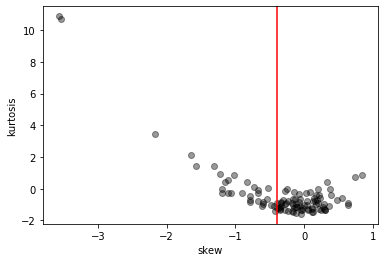

In [4]:
plt.scatter(phase['skew'],phase['kurtosis'],color='black',alpha=0.4)
plt.ylabel('kurtosis')
plt.xlabel('skew')
plt.axvline(-0.4,color='red') #initial cut

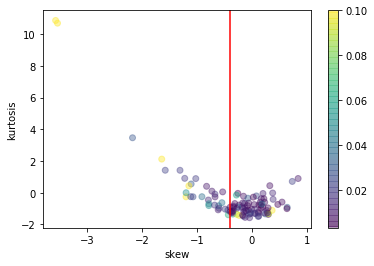

In [5]:
plt.scatter(phase['skew'],phase['kurtosis'],c=phase['amp'],alpha=0.4,vmax=.1)
plt.ylabel('kurtosis')
plt.xlabel('skew')
plt.axvline(-0.4,color='red') #initial cut
plt.colorbar()

#### first just cut by skew

In [6]:
fred = phase[phase['skew']<-0.5]

In [7]:
sine = phase[phase['skew']>-0.5]

In [8]:
len(fred)

28

empty file for OIII I


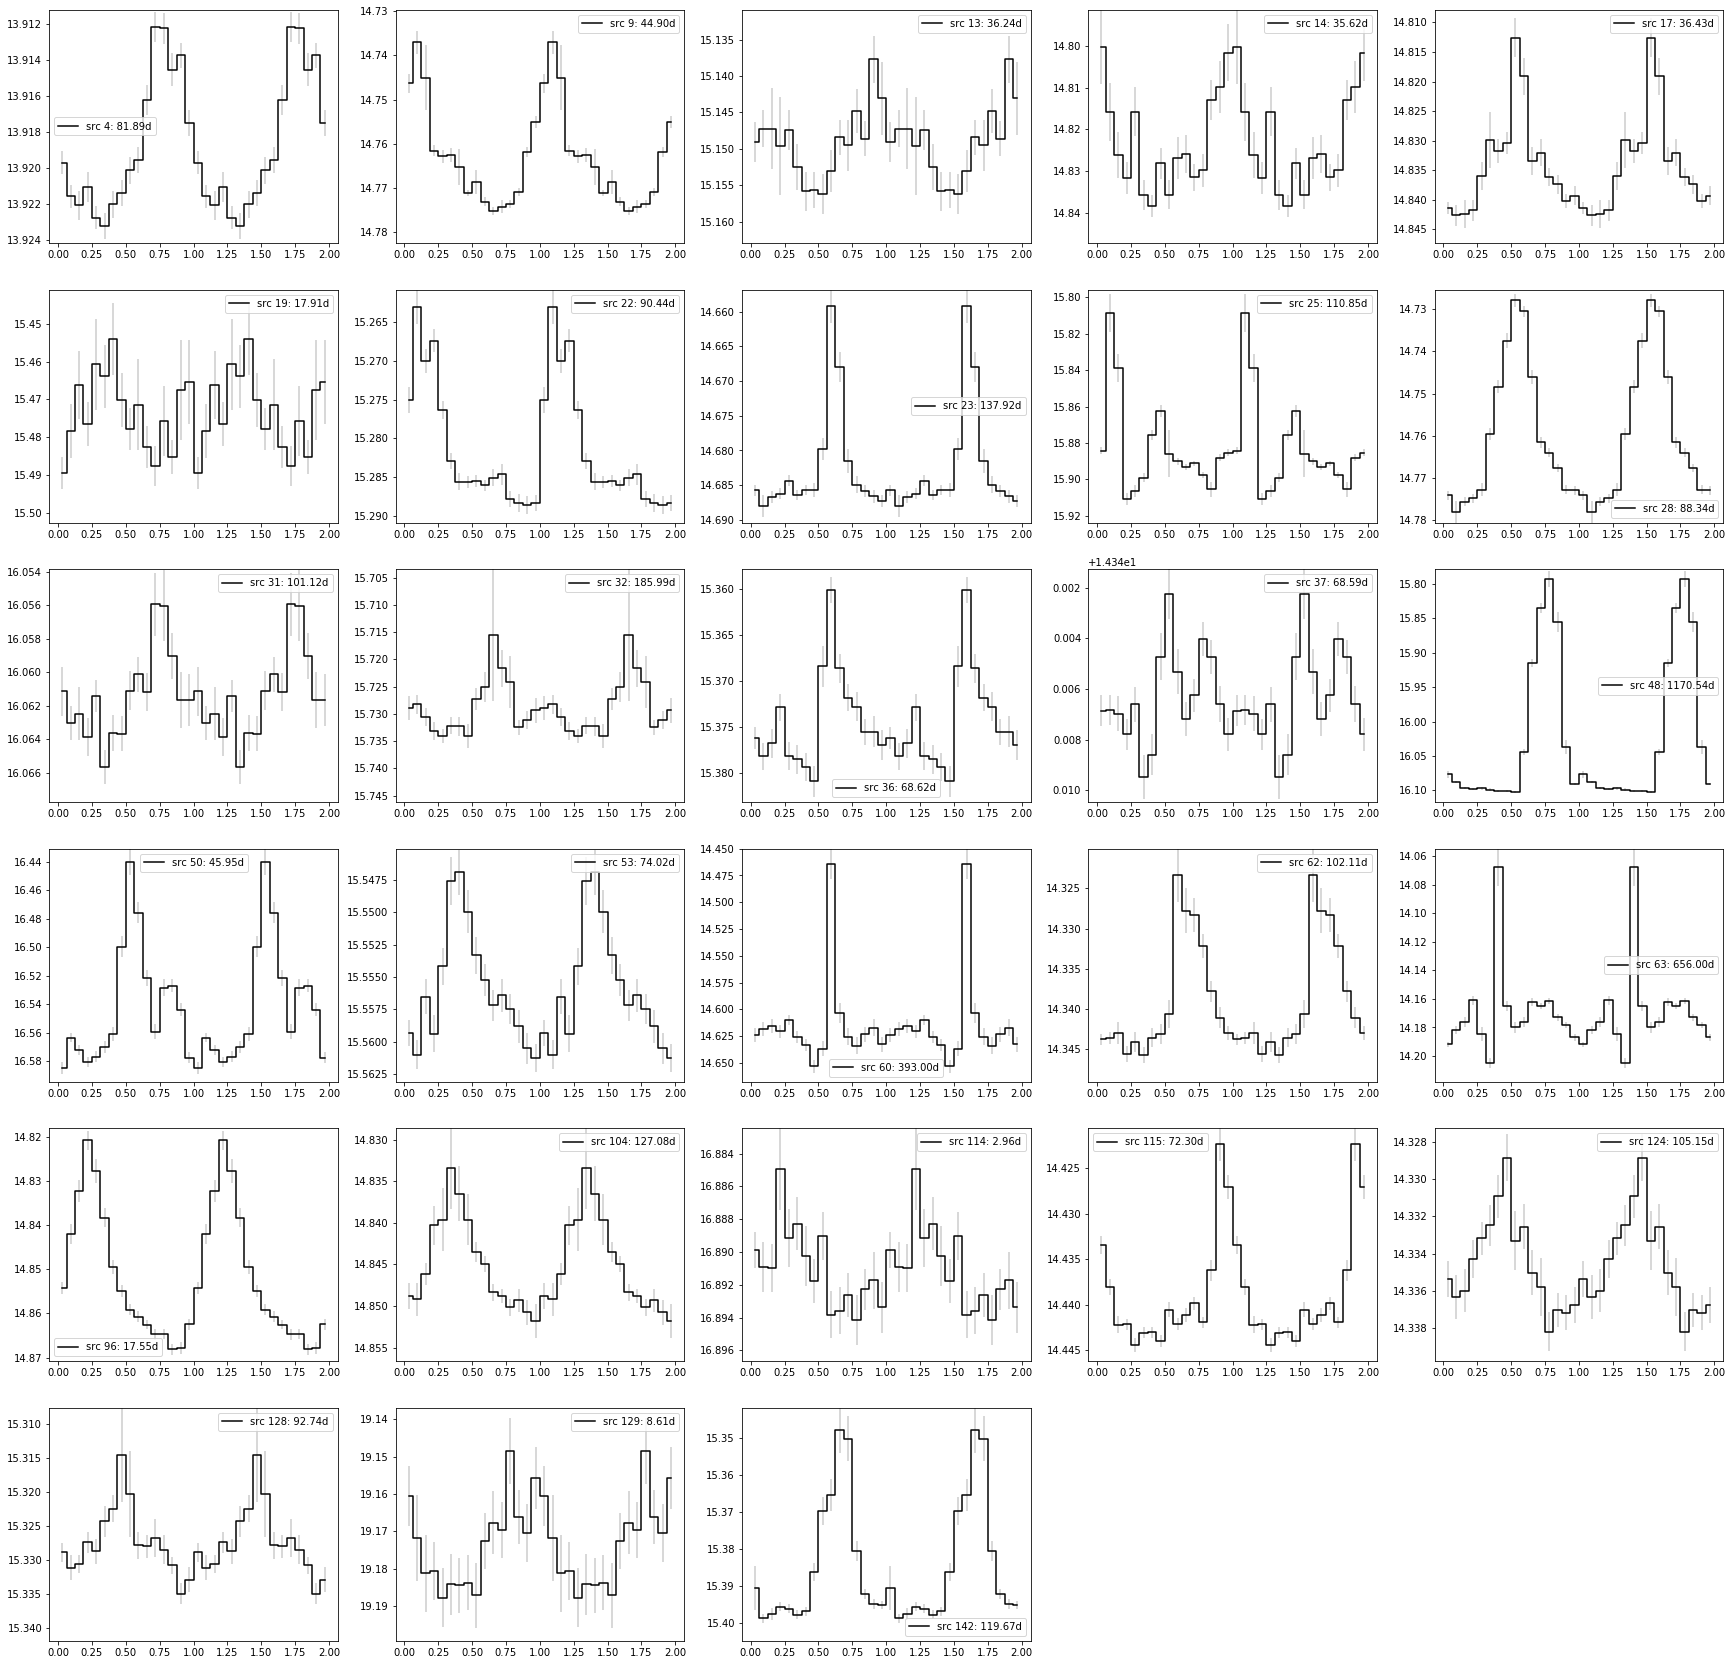

In [35]:
fig = plt.figure(figsize=(30,30))
i = 1
for f in fred.index:
    #get source number and period
    num = phase.loc[f]['src_n']
    pd = phase.loc[f]['period']
    if num in cross['src_n']: c=cross; m=mlist1
    else: c=cross2;m=mlist2
    iband,vband = o.getIV(num,c,mlist=m,stack=True)
    #detrend if period above 200
    if pd<200: 
        o.splinedetrend(iband,window=100,btol=50)
        mag = iband['I detrend']
        det = True
    else: mag = iband['I mag']; det=False
    ax = fig.add_subplot(6,5,i)
    #get step function
    mid,avg,err = o.meanphase(iband,pd,pbins=16,det=det,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
    ax.step(mid,avg,where='mid',color='black',label=f'src {num}: {pd:.2f}d')
    ax.errorbar(mid,avg,yerr=err,ls='none',color='grey',alpha=0.4)
    maxi,mini = np.max(avg),np.min(avg)
    ax.set_ylim(maxi+np.max(err),mini-np.max(err))
    ax.legend()
    i+=1

#### eventually analyze the tall, nearly symmetrical sources
- b/c they could be nearby to the actual period, s.t. some of the high amplitude from flares is distributed in phase?
    - or a beat period? not sure what the mechanism would be but occurred for the 362 day period

### repeat for potentially sinusoidal sources


In [37]:
len(sine)

78

In [41]:
78/5

15.6

FRED in sine bin: 40,45,54,69,79
- not as skinny
- skew all less than -0.1

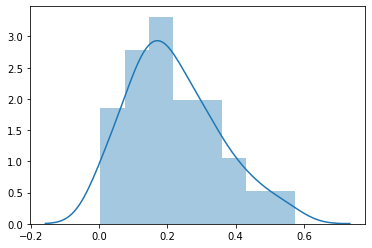

In [9]:
sb.distplot(phase['symm sum']/phase['amp'])

In [10]:
for i in [40,45,54]: #69 and 79 look potentially FRED at 16 bins but not more (~30)
    pdict = phase[phase['src_n']==i]
    print('skew: ',float(pdict['skew']))
    print('kurtosis: ',float(pdict['kurtosis']))
    
#     print('symm sum/amp: ',float(pdict['symm sum'])/float(pdict['amp']))
#for each, skew either decent or symm sum/amp high

skew:  -0.2580939898378453
kurtosis:  -0.8976786945211117
skew:  -0.4280663018947542
kurtosis:  -1.3934481315342253
skew:  -0.4353178030223902
kurtosis:  -1.0986928568276024


empty file for OII I


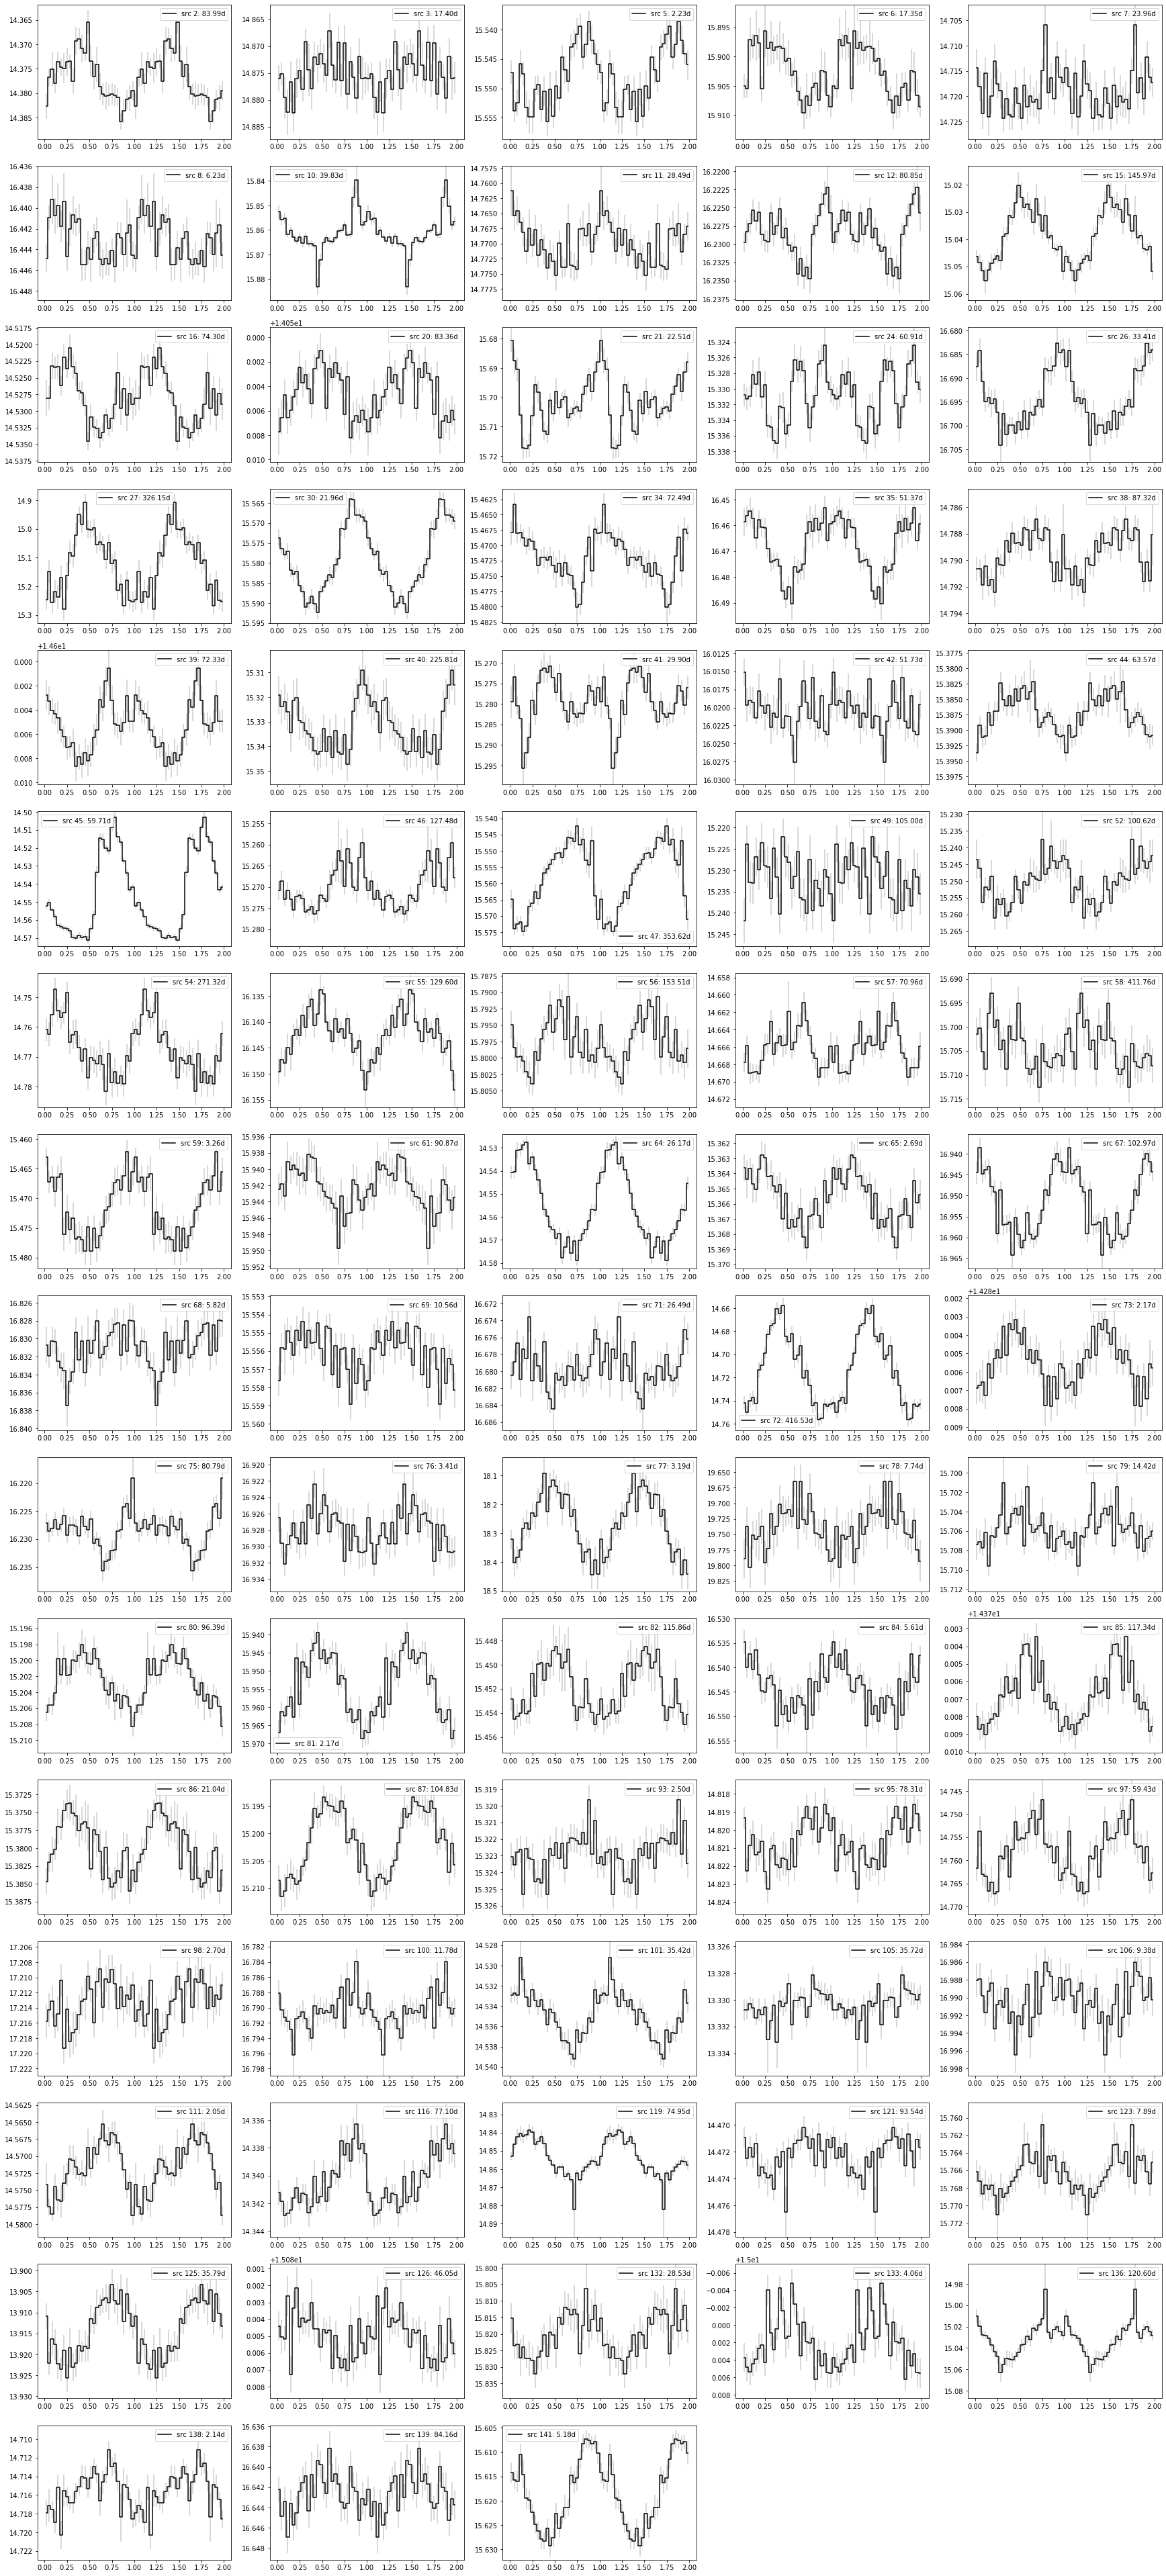

In [59]:
fig = plt.figure(figsize=(30,70))
i = 1
for f in sine.index:
    #get source number and period
    num = phase.loc[f]['src_n']
    pd = phase.loc[f]['period']
    if num in cross['src_n']: c=cross; m=mlist1
    else: c=cross2;m=mlist2
    iband,vband = o.getIV(num,c,mlist=m,stack=True)
    #detrend if period above 200
    if pd<200: 
        o.splinedetrend(iband,window=100,btol=50)
        mag = iband['I detrend']
        det = True
    else: mag = iband['I mag']; det=False
    ax = fig.add_subplot(16,5,i)
    #get step function
    mid,avg,err = o.meanphase(iband,pd,pbins=30,det=det,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
    ax.step(mid,avg,where='mid',color='black',label=f'src {num}: {pd:.2f}d')
    ax.errorbar(mid,avg,yerr=err,ls='none',color='grey',alpha=0.4)
    maxi,mini = np.max(avg),np.min(avg)
    ax.set_ylim(maxi+np.max(err),mini-np.max(err))
    ax.legend()
    i+=1

(0, 0.2)

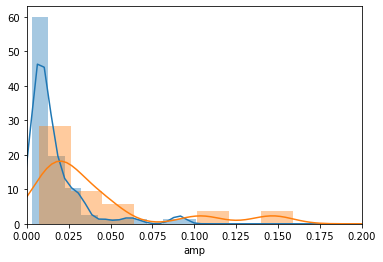

In [11]:
sb.distplot(sine['amp']) #more sine at very low amplitude
sb.distplot(fred['amp'])
plt.xlim(0,0.2)

(0, 0.02)

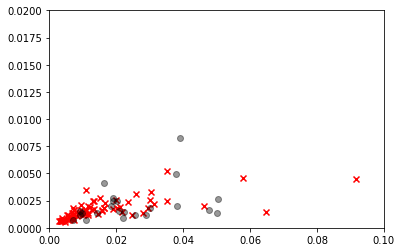

In [12]:
plt.scatter(sine['amp'],sine['mean err'],color='red',marker='x')
plt.scatter(fred['amp'],fred['mean err'],color='black',alpha=0.4)
plt.xlim(0,.1)
plt.ylim(0,.02)

(0, 0.05)

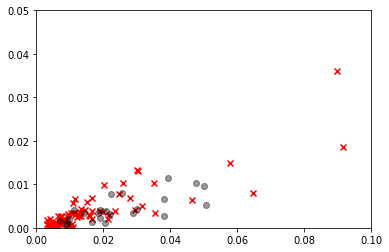

In [13]:
plt.scatter(sine['amp'],sine['symm sum'],color='red',marker='x')
plt.scatter(fred['amp'],fred['symm sum'],color='black',alpha=0.4)
plt.xlim(0,.1)
plt.ylim(0,.05)

### investigate turnaround in kurtosis-skew trend

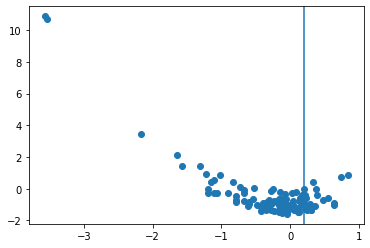

In [24]:
plt.scatter(phase['skew'],phase['kurtosis'])
plt.axvline(0.2)

In [25]:
turn = phase[phase['skew']>0.2]

In [26]:
len(turn)

20

as you can see below -- and as is apparent from the positive skew values -- these sourrces after the turnaround have very few faint bins
- essentially look like FRED profiles upside down
- not necessarily sinusoidal, so not sure what they represent; **any of them trustworhty?**

empty file for OII I


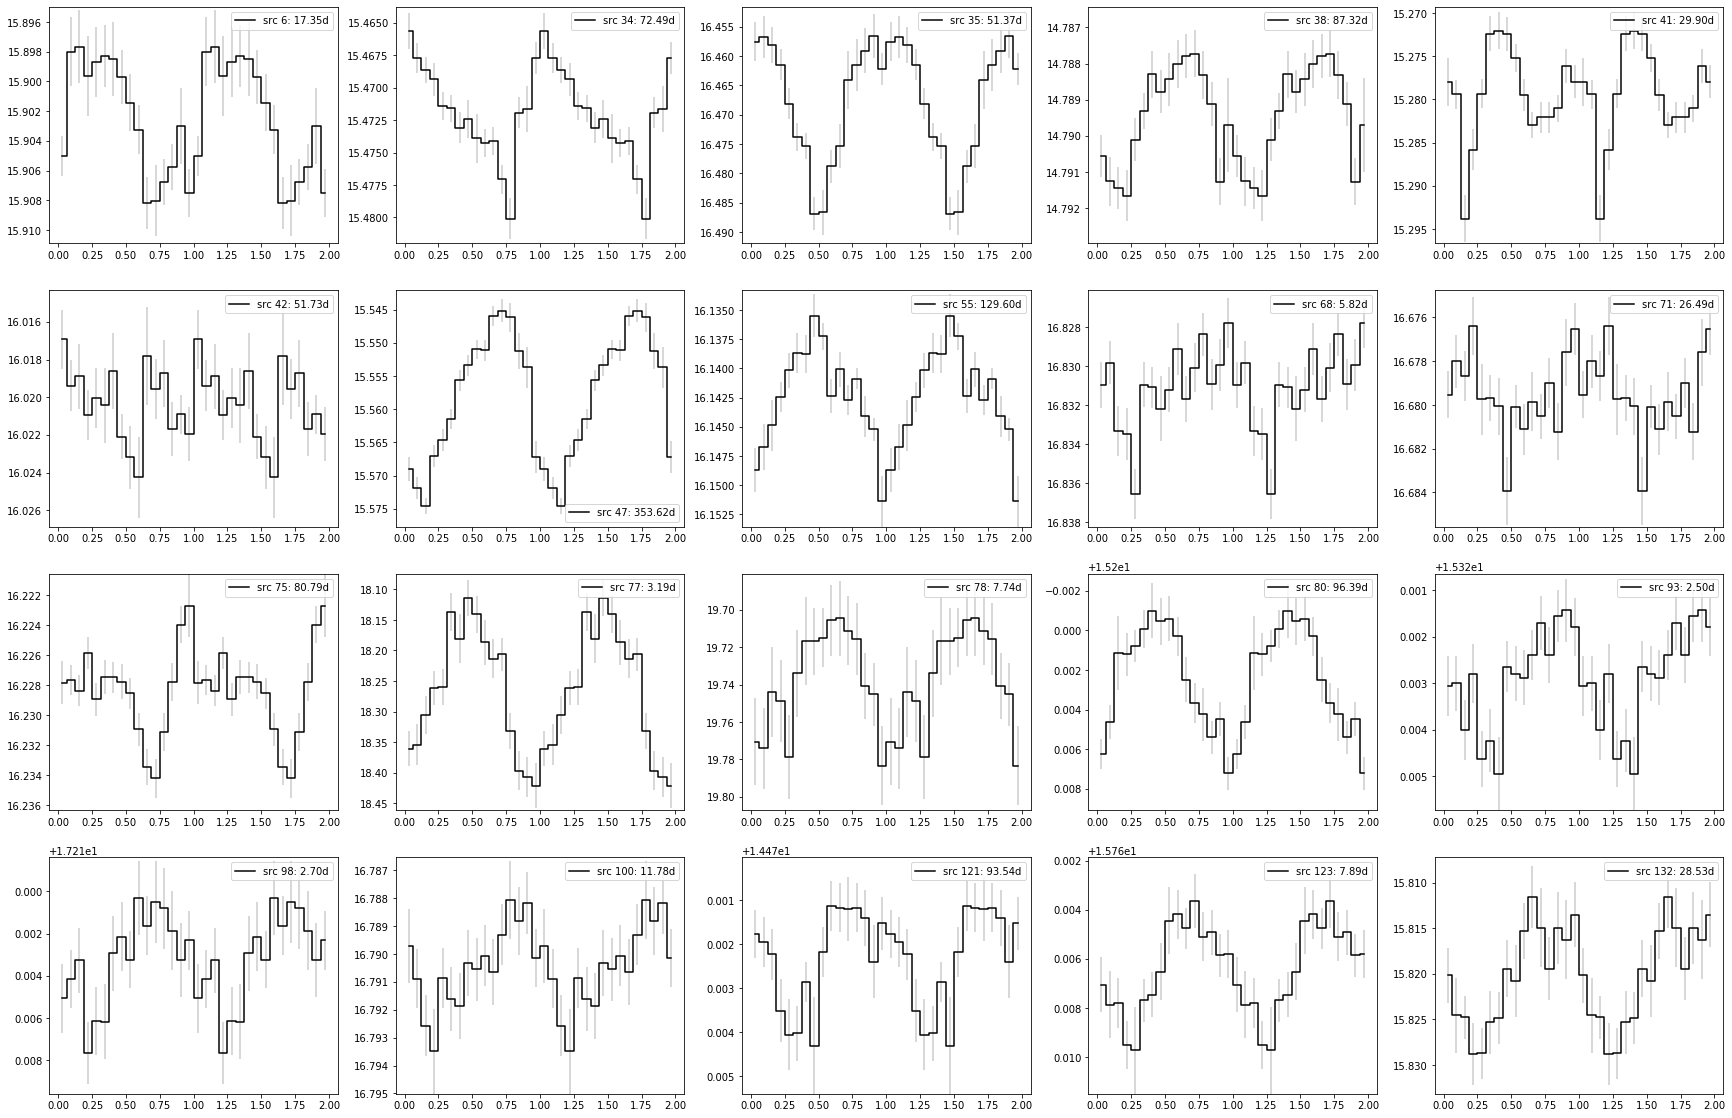

In [29]:
fig = plt.figure(figsize=(30,20))
i = 1
for f in turn.index:
    num = phase.loc[f]['src_n']
    pd = phase.loc[f]['period']
    if num in cross['src_n']: c=cross; m=mlist1
    else: c=cross2;m=mlist2
    iband,vband = o.getIV(num,c,mlist=m,stack=True)
    #detrend if period above 200
    if pd<200: 
        o.splinedetrend(iband,window=100,btol=50)
        mag = iband['I detrend']
        det = True
    else: mag = iband['I mag']; det=False
    ax = fig.add_subplot(4,5,i)
    #get step function
    mid,avg,err = o.meanphase(iband,pd,pbins=16,det=det,med=False,double=True,stdev=True,epoch=0,divide=True,sterr=True)
    ax.step(mid,avg,where='mid',color='black',label=f'src {num}: {pd:.2f}d')
    ax.errorbar(mid,avg,yerr=err,ls='none',color='grey',alpha=0.4)
    maxi,mini = np.max(avg),np.min(avg)
    ax.set_ylim(maxi+np.max(err),mini-np.max(err))
    ax.legend()
    i+=1   

### future: can relax skew cut, maybe introduce kurtosis cut off

In [17]:
# fred2 = phase[phase['skew']<-0.1]
# fred2 = phase[phase['kurtosis']>-1]
# sin2 = phase[phase['skew']>-0.1]
# sin2 = phase[phase['kurtosis']<-1]